In [1]:
import torch
from torch import nn
from load_mnist import load_mnist
import matplotlib.pyplot as plt
import numpy as np
from time import time
np.random.seed(0)

## 1.1 Multi Layer Fully Connected Network

In [2]:
def training_curve_plot(title, train_losses, test_losses, train_accuracy, test_accuracy):
    """ 
    convenience function for plotting train and test loss and accuracy
    """
    lg=13
    md=8
    sm=7
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    fig.suptitle(title, fontsize=md)
    x = range(1, len(train_losses)+1)
    axs[0].plot(x, train_losses, label=f'Final train loss: {train_losses[-1]:.4f}')
    axs[0].plot(x, test_losses, label=f'Final test loss: {test_losses[-1]:.4f}')
    axs[0].set_title('Losses', fontsize=md)
    axs[0].set_xlabel('Iteration', fontsize=md)
    axs[0].set_ylabel('Loss', fontsize=md)
    axs[0].legend(fontsize=sm)
    axs[0].tick_params(axis='both', labelsize=sm)
    # Optionally use a logarithmic y-scale
    #axs[0].set_yscale('log')
    axs[0].grid(True, which="both", linestyle='--', linewidth=0.5)
    axs[1].plot(x, train_accuracy, label=f'Final train accuracy: {train_accuracy[-1]:.4f}%')
    axs[1].plot(x, test_accuracy, label=f'Final test accuracy: {test_accuracy[-1]:.4f}%')
    axs[1].set_title('Accuracy', fontsize=md)
    axs[1].set_xlabel('Iteration', fontsize=md)
    axs[1].set_ylabel('Accuracy (%)', fontsize=sm)
    axs[1].legend(fontsize=sm)
    axs[1].tick_params(axis='both', labelsize=sm)
    axs[1].grid(True, which="both", linestyle='--', linewidth=0.5)
    plt.show()

In [58]:
#Network architecture
# Implement a 2-layer neural network
class Net(nn.Module):
    """
    2 layer neural network with relu acitvation functions
    """
    def __init__(self, input_size, hidden_size_1, hidden_size_2, num_classes):
        """
        Initialize the model by setting up the two linear layers.
        Args:
            input_size: The number of input features in your training/test data
            hidden_size_1: The size of the hidden layer in the network
            hidden_size_2: The size of the hidden layer in the network
            num_classes: The size of the output layer, i.e. the number of classes
        """
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size_1)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size_2, num_classes)
        
    def forward(self, x):
        """
        Perform a forward pass of our model on input features, x.
        Args:
            x: A batch of input features of size (batch_size, input_size)
        """
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
       
        return out

In [4]:
#Load MNIST dataset
x_train, y_train, x_test, y_test = load_mnist()

In [57]:

bz = 64



# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(x_train, dtype=torch.float32)
X_train_3Dtensor = torch.tensor(x_train, dtype=torch.float32).view(-1, 1, 28, 28)
Y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(x_test, dtype=torch.float32)
X_test_3Dtensor = torch.tensor(x_test, dtype=torch.float32).view(-1, 1, 28, 28)
Y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_set = torch.utils.data.TensorDataset(X_train_tensor, Y_train_tensor)
test_set = torch.utils.data.TensorDataset(X_test_tensor, Y_test_tensor)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=bz, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=bz, shuffle=False)

train_3d = torch.utils.data.TensorDataset(X_train_3Dtensor, Y_train_tensor)
train_loader_3d = torch.utils.data.DataLoader(train_3d, batch_size=bz, shuffle=True)
test_3d = torch.utils.data.TensorDataset(X_test_3Dtensor, Y_test_tensor)
test_loader_3d = torch.utils.data.DataLoader(test_3d, batch_size=bz, shuffle=False)

In [59]:
def train_network(model: nn.Module, criteria: nn.Module, 
                  optimizer: torch.optim.Optimizer, num_epochs: int, train_loader: torch.utils.data.DataLoader, 
                  test_loader: torch.utils.data.DataLoader, device: torch.device, model_name: str, lr: float) -> None:
    """
    Train a neural network model
    
    Args:
        model: The neural network model to be trained
        criteria: The loss function
        optimizer: The optimizer
        num_epochs: The number of epochs to train the model
        train_loader: The training data loader
        test_loader: The test data loader
        device: The device to run the model on
    """
    train_costs = []
    test_costs = []
    train_accuracy = []
    test_accuracy = []
    start = time()
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            
            outputs = model(images)
            loss = criteria(outputs, torch.argmax(labels, dim=1))
            train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(torch.argmax(labels, dim=1)).sum().item()
        
        train_costs.append(train_loss / len(train_loader))
        train_accuracy.append(100 * correct / total)
    
        model.eval()
        test_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for i, (images, labels) in enumerate(test_loader):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criteria(outputs, torch.argmax(labels, dim=1))
                test_loss += loss.item()

                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(torch.argmax(labels, dim=1)).sum().item()
            
            test_costs.append(test_loss / len(test_loader))
            test_accuracy.append(100 * correct / total)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_costs[-1]:.4f}, Test Loss: {test_costs[-1]:.4f}, Train Accuracy: {train_accuracy[-1]:.4f}%, Test Accuracy: {test_accuracy[-1]:.4f}%')
    total = time() - start
    
    plot_title = model_name + " - lr: " + str(lr) + " - Total Time: " + str(total // 60) + "min " + str(total % 60) + "s " + "-Epochs: " + str(num_epochs)
    return plot_title, train_costs, test_costs, train_accuracy, test_accuracy
    
            
    

In [60]:
#Hyperparameters
models = {}
input_size = 28*28
hidden_size_1 = 512
hidden_size_2 = 256
num_classes = 10
num_epochs = 100
learning_rate = 0.01

Epoch 1/100, Train Loss: 1.6280, Test Loss: 0.6971, Train Accuracy: 62.1367%, Test Accuracy: 83.3600%
Epoch 2/100, Train Loss: 0.5115, Test Loss: 0.3944, Train Accuracy: 86.7217%, Test Accuracy: 88.9800%
Epoch 3/100, Train Loss: 0.3731, Test Loss: 0.3301, Train Accuracy: 89.4967%, Test Accuracy: 90.6100%
Epoch 4/100, Train Loss: 0.3286, Test Loss: 0.3007, Train Accuracy: 90.6250%, Test Accuracy: 91.3800%
Epoch 5/100, Train Loss: 0.3012, Test Loss: 0.2793, Train Accuracy: 91.3450%, Test Accuracy: 91.9400%
Epoch 6/100, Train Loss: 0.2800, Test Loss: 0.2625, Train Accuracy: 91.9917%, Test Accuracy: 92.5600%
Epoch 7/100, Train Loss: 0.2618, Test Loss: 0.2457, Train Accuracy: 92.5400%, Test Accuracy: 93.0900%
Epoch 8/100, Train Loss: 0.2451, Test Loss: 0.2362, Train Accuracy: 92.9700%, Test Accuracy: 93.4300%
Epoch 9/100, Train Loss: 0.2301, Test Loss: 0.2190, Train Accuracy: 93.4700%, Test Accuracy: 93.8100%
Epoch 10/100, Train Loss: 0.2164, Test Loss: 0.2089, Train Accuracy: 93.8650%, Tes

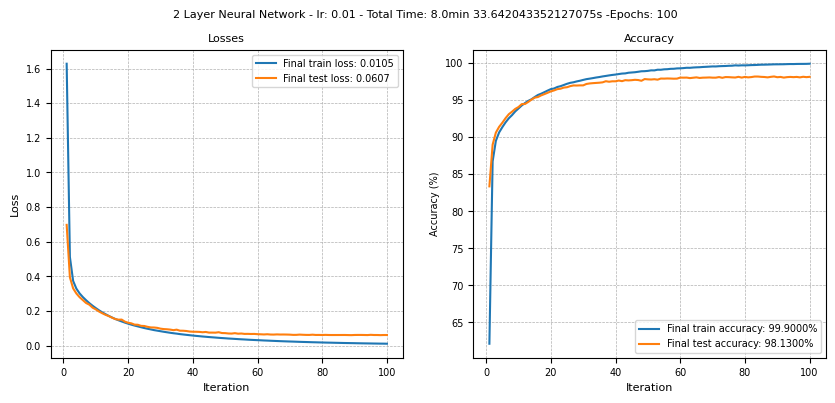

In [61]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Net(input_size, hidden_size_1, hidden_size_2, num_classes).to(device)
criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
model_name = '2 Layer Neural Network'
models["2lnn"] = train_network(model, criteria, optimizer, num_epochs, train_loader, test_loader, device, model_name, learning_rate)
training_curve_plot(*models["2lnn"])

## 1.2 Multi-Layer CNN


In [9]:
class mlconvnet(nn.Module):
    def __init__(self):
        super(mlconvnet, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, 1, 1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(8, 16, 3, 1, 1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(2, 2)
        
        self.conv3 = nn.Conv2d(16, 32, 3, 1, 1)
        self.relu3 = nn.ReLU()
        self.fc1 = nn.Linear(32*7*7, 10)
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        
        x = self.conv3(x)
        x = self.relu3(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)

        return x


Epoch 1/50, Train Loss: 1.2994, Test Loss: 0.4142, Train Accuracy: 62.1300%, Test Accuracy: 85.8300%
Epoch 2/50, Train Loss: 0.2781, Test Loss: 0.2220, Train Accuracy: 91.6283%, Test Accuracy: 93.4000%
Epoch 3/50, Train Loss: 0.1804, Test Loss: 0.1470, Train Accuracy: 94.5833%, Test Accuracy: 95.1900%
Epoch 4/50, Train Loss: 0.1350, Test Loss: 0.1209, Train Accuracy: 95.8900%, Test Accuracy: 96.1000%
Epoch 5/50, Train Loss: 0.1111, Test Loss: 0.1119, Train Accuracy: 96.6583%, Test Accuracy: 96.3400%
Epoch 6/50, Train Loss: 0.0953, Test Loss: 0.0806, Train Accuracy: 97.1517%, Test Accuracy: 97.3400%
Epoch 7/50, Train Loss: 0.0846, Test Loss: 0.0915, Train Accuracy: 97.4450%, Test Accuracy: 97.1800%
Epoch 8/50, Train Loss: 0.0769, Test Loss: 0.0644, Train Accuracy: 97.6817%, Test Accuracy: 97.8700%
Epoch 9/50, Train Loss: 0.0705, Test Loss: 0.0586, Train Accuracy: 97.9100%, Test Accuracy: 98.1000%
Epoch 10/50, Train Loss: 0.0656, Test Loss: 0.0537, Train Accuracy: 98.0650%, Test Accuracy

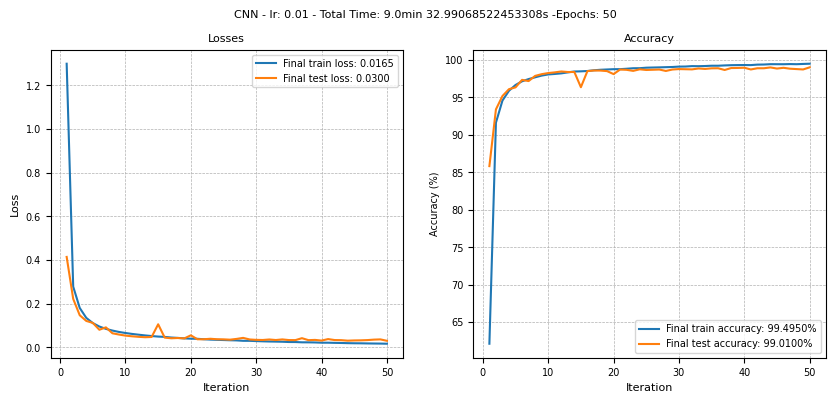

In [10]:
# Create a multi layer conv net
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
convenet = mlconvnet().to(device)
criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(convenet.parameters(), lr=learning_rate)
name = 'CNN'
models["cnn"] = train_network(convenet, criteria, optimizer, num_epochs, train_loader_3d, test_loader_3d, device, name, learning_rate)
training_curve_plot(*models["cnn"])

## 1.3 Swap orders of max pool and activation function

In [11]:
class mlconvnetorderwap(nn.Module):
    def __init__(self):
        super(mlconvnetorderwap, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, 1, 1)
        self.maxpool1 = nn.MaxPool2d(2, 2)
        self.relu1 = nn.ReLU()
        

        self.conv2 = nn.Conv2d(8, 16, 3, 1, 1)
        self.maxpool2 = nn.MaxPool2d(2, 2)
        self.relu2 = nn.ReLU()
       
        
        self.conv3 = nn.Conv2d(16, 32, 3, 1, 1)
        self.relu3 = nn.ReLU()
        self.fc1 = nn.Linear(32*7*7, 10)
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.relu1(x)
        

        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.relu2(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)

        return x

Epoch 1/50, Train Loss: 1.1859, Test Loss: 0.3605, Train Accuracy: 65.4583%, Test Accuracy: 89.1400%
Epoch 2/50, Train Loss: 0.2961, Test Loss: 0.2312, Train Accuracy: 91.0117%, Test Accuracy: 93.1400%
Epoch 3/50, Train Loss: 0.2017, Test Loss: 0.1666, Train Accuracy: 93.9400%, Test Accuracy: 95.2100%
Epoch 4/50, Train Loss: 0.1486, Test Loss: 0.1333, Train Accuracy: 95.5683%, Test Accuracy: 96.0700%
Epoch 5/50, Train Loss: 0.1174, Test Loss: 0.1184, Train Accuracy: 96.4467%, Test Accuracy: 96.2700%
Epoch 6/50, Train Loss: 0.0991, Test Loss: 0.0935, Train Accuracy: 96.9650%, Test Accuracy: 97.0500%
Epoch 7/50, Train Loss: 0.0866, Test Loss: 0.0770, Train Accuracy: 97.3833%, Test Accuracy: 97.4800%
Epoch 8/50, Train Loss: 0.0782, Test Loss: 0.0705, Train Accuracy: 97.6667%, Test Accuracy: 97.6900%
Epoch 9/50, Train Loss: 0.0713, Test Loss: 0.0636, Train Accuracy: 97.8283%, Test Accuracy: 97.9200%
Epoch 10/50, Train Loss: 0.0668, Test Loss: 0.0633, Train Accuracy: 97.9333%, Test Accuracy

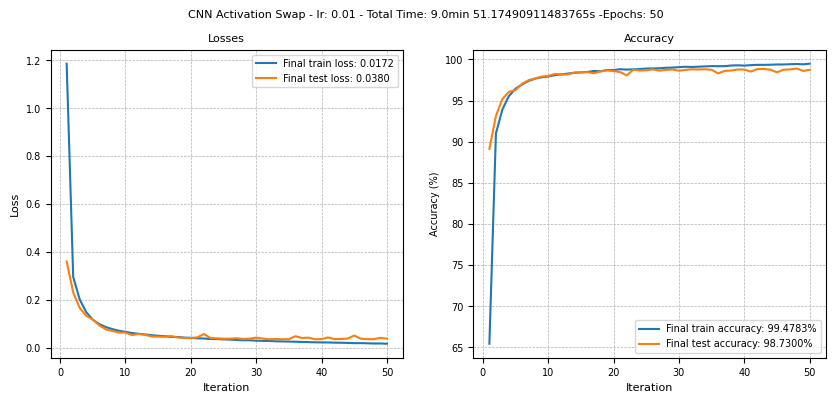

In [12]:
swap = mlconvnetorderwap().to(device)
criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(swap.parameters(), lr=learning_rate)
name = 'CNN Activation Swap'
models["cnnswap"] =train_network(swap, criteria, optimizer, num_epochs, train_loader_3d, test_loader_3d, device, name, learning_rate)
training_curve_plot(*models["cnnswap"])

Epoch 1/50, Train Loss: 1.3129, Test Loss: 0.4499, Train Accuracy: 64.0417%, Test Accuracy: 87.6600%
Epoch 2/50, Train Loss: 0.3867, Test Loss: 0.3211, Train Accuracy: 88.8450%, Test Accuracy: 90.5500%
Epoch 3/50, Train Loss: 0.3052, Test Loss: 0.2649, Train Accuracy: 91.0150%, Test Accuracy: 92.2400%
Epoch 4/50, Train Loss: 0.2563, Test Loss: 0.2227, Train Accuracy: 92.3750%, Test Accuracy: 93.5700%
Epoch 5/50, Train Loss: 0.2158, Test Loss: 0.1872, Train Accuracy: 93.6167%, Test Accuracy: 94.6400%
Epoch 6/50, Train Loss: 0.1818, Test Loss: 0.1587, Train Accuracy: 94.6500%, Test Accuracy: 95.4300%
Epoch 7/50, Train Loss: 0.1547, Test Loss: 0.1348, Train Accuracy: 95.4717%, Test Accuracy: 96.1400%
Epoch 8/50, Train Loss: 0.1346, Test Loss: 0.1169, Train Accuracy: 96.0917%, Test Accuracy: 96.5300%
Epoch 9/50, Train Loss: 0.1200, Test Loss: 0.1052, Train Accuracy: 96.4917%, Test Accuracy: 96.8800%
Epoch 10/50, Train Loss: 0.1093, Test Loss: 0.0963, Train Accuracy: 96.8050%, Test Accuracy

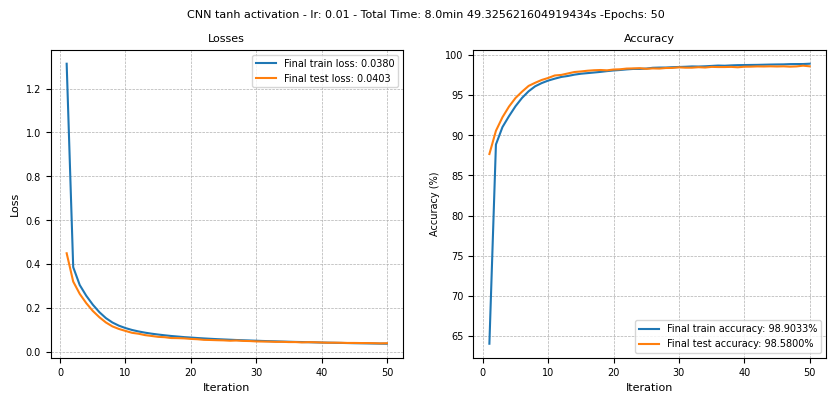

In [13]:
# b) Swap to hyperbolic instead of ReLU activations

class mlconvnethyperbolic(nn.Module):
    def __init__(self):
        super(mlconvnethyperbolic, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, 1, 1)
        self.maxpool1 = nn.MaxPool2d(2, 2)
        self.relu1 = nn.Tanh()
        

        self.conv2 = nn.Conv2d(8, 16, 3, 1, 1)
        self.maxpool2 = nn.MaxPool2d(2, 2)
        self.relu2 = nn.Tanh()
        
        self.conv3 = nn.Conv2d(16, 32, 3, 1, 1)
        self.relu3 = nn.Tanh()
        self.fc1 = nn.Linear(32*7*7, 10)
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.relu1(x)
    
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.relu2(x)
        
        x = self.conv3(x)
        x = self.relu3(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)

        return x

hyperbolic = mlconvnethyperbolic().to(device)
criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(hyperbolic.parameters(), lr=learning_rate)
name = 'CNN tanh activation'
models["cnn tanh"] = train_network(hyperbolic, criteria, optimizer, num_epochs, train_loader_3d, test_loader_3d, device, name, learning_rate)
training_curve_plot(*models["cnn tanh"])


## 1.4 ADAM instead of SGD

Epoch 1/50, Train Loss: 0.1379, Test Loss: 0.0480, Train Accuracy: 95.6767%, Test Accuracy: 98.4800%
Epoch 2/50, Train Loss: 0.0619, Test Loss: 0.0688, Train Accuracy: 98.1033%, Test Accuracy: 97.7900%
Epoch 3/50, Train Loss: 0.0625, Test Loss: 0.0652, Train Accuracy: 98.1500%, Test Accuracy: 97.9700%
Epoch 4/50, Train Loss: 0.0576, Test Loss: 0.0621, Train Accuracy: 98.2867%, Test Accuracy: 98.3300%
Epoch 5/50, Train Loss: 0.0556, Test Loss: 0.0745, Train Accuracy: 98.3900%, Test Accuracy: 98.0500%
Epoch 6/50, Train Loss: 0.0512, Test Loss: 0.0582, Train Accuracy: 98.4917%, Test Accuracy: 98.4400%
Epoch 7/50, Train Loss: 0.0501, Test Loss: 0.0710, Train Accuracy: 98.5500%, Test Accuracy: 98.1300%
Epoch 8/50, Train Loss: 0.0516, Test Loss: 0.0647, Train Accuracy: 98.5650%, Test Accuracy: 98.3500%
Epoch 9/50, Train Loss: 0.0486, Test Loss: 0.0725, Train Accuracy: 98.6033%, Test Accuracy: 98.3200%
Epoch 10/50, Train Loss: 0.0545, Test Loss: 0.0633, Train Accuracy: 98.5250%, Test Accuracy

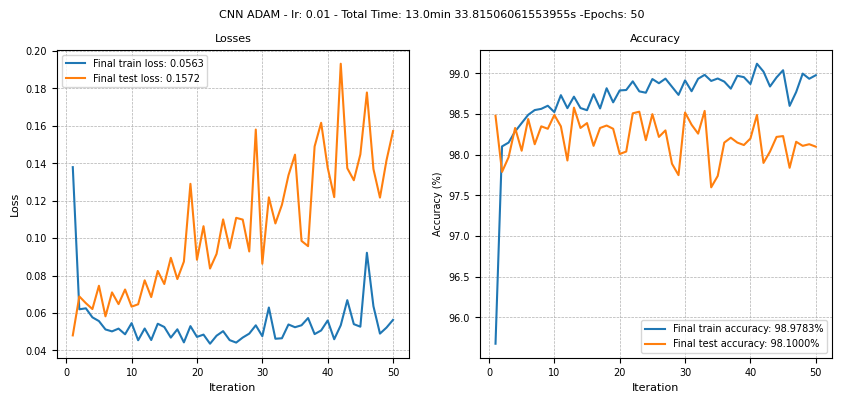

In [16]:
adam_net = mlconvnet().to(device)
adam_optim = torch.optim.Adam(adam_net.parameters(), lr=learning_rate)
adam = 'CNN ADAM'
models["cnn_adam"] = train_network(adam_net, criteria, adam_optim, num_epochs, train_loader_3d, test_loader_3d, device, adam, learning_rate)
training_curve_plot(*models["cnn_adam"])


## 1.5 CNN three variants
Base model Architecture
 - Conv 8x3x3x1 stride 1 padding 1
 - Relu
 - Pool 

 - Conv 16x3x3x8 stride 1 padding 1
 - Relu
 - Pool

 - Conv 32x3x3x16 stride 1 padding 1
 - Relu
 - FC 32x7x7 in, 10 out

 Optimizer: SGD
 Loss : Cross Entropy
 Batch size: 64
 Epochs : 50
 
Variants: i: Nesterov acceleration, ii: L2 regularization, iii: Dropout layer after last convolution before full connected

#### 1.5 i Nesterov acceleration



In [17]:
modeli = mlconvnet()
optimizer = torch.optim.SGD(modeli.parameters(), lr=learning_rate, nesterov = True, momentum = 0.9)

models["nesterov"] = train_network(modeli, criteria, optimizer, num_epochs, train_loader_3d, test_loader_3d, device, 'CNN Nesterov', learning_rate)

Epoch 1/50, Train Loss: 0.3298, Test Loss: 0.0894, Train Accuracy: 89.3767%, Test Accuracy: 97.2700%
Epoch 2/50, Train Loss: 0.0813, Test Loss: 0.0580, Train Accuracy: 97.4850%, Test Accuracy: 98.1700%
Epoch 3/50, Train Loss: 0.0589, Test Loss: 0.0512, Train Accuracy: 98.1533%, Test Accuracy: 98.2300%
Epoch 4/50, Train Loss: 0.0483, Test Loss: 0.0423, Train Accuracy: 98.5417%, Test Accuracy: 98.7200%
Epoch 5/50, Train Loss: 0.0410, Test Loss: 0.0348, Train Accuracy: 98.7733%, Test Accuracy: 98.9400%
Epoch 6/50, Train Loss: 0.0359, Test Loss: 0.0348, Train Accuracy: 98.8583%, Test Accuracy: 98.8700%
Epoch 7/50, Train Loss: 0.0313, Test Loss: 0.0596, Train Accuracy: 98.9917%, Test Accuracy: 98.0500%
Epoch 8/50, Train Loss: 0.0268, Test Loss: 0.0378, Train Accuracy: 99.1783%, Test Accuracy: 98.8300%
Epoch 9/50, Train Loss: 0.0250, Test Loss: 0.0355, Train Accuracy: 99.1967%, Test Accuracy: 98.8800%
Epoch 10/50, Train Loss: 0.0211, Test Loss: 0.0363, Train Accuracy: 99.3550%, Test Accuracy

1.5 ii L2 regularization

In [18]:
modelii = mlconvnet()
optimizer = torch.optim.SGD(modelii.parameters(), lr=learning_rate, weight_decay = 1e-4)
models["L2"] = train_network(modelii, criteria, optimizer, num_epochs, train_loader_3d, test_loader_3d, device, 'CNN L2', learning_rate)

Epoch 1/50, Train Loss: 0.9769, Test Loss: 0.3095, Train Accuracy: 71.2100%, Test Accuracy: 90.8000%
Epoch 2/50, Train Loss: 0.2604, Test Loss: 0.2023, Train Accuracy: 92.1117%, Test Accuracy: 93.8800%
Epoch 3/50, Train Loss: 0.1733, Test Loss: 0.1687, Train Accuracy: 94.8433%, Test Accuracy: 94.8200%
Epoch 4/50, Train Loss: 0.1297, Test Loss: 0.1061, Train Accuracy: 96.1917%, Test Accuracy: 96.8600%
Epoch 5/50, Train Loss: 0.1075, Test Loss: 0.0967, Train Accuracy: 96.7783%, Test Accuracy: 97.0500%
Epoch 6/50, Train Loss: 0.0926, Test Loss: 0.0873, Train Accuracy: 97.2633%, Test Accuracy: 97.2600%
Epoch 7/50, Train Loss: 0.0829, Test Loss: 0.0754, Train Accuracy: 97.5550%, Test Accuracy: 97.6600%
Epoch 8/50, Train Loss: 0.0757, Test Loss: 0.0670, Train Accuracy: 97.6750%, Test Accuracy: 97.8100%
Epoch 9/50, Train Loss: 0.0701, Test Loss: 0.0612, Train Accuracy: 97.8983%, Test Accuracy: 98.1400%
Epoch 10/50, Train Loss: 0.0651, Test Loss: 0.0605, Train Accuracy: 98.0117%, Test Accuracy

In [19]:
class cnn_drop(nn.Module):
    def __init__(self):
        super(cnn_drop, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, 1, 1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(8, 16, 3, 1, 1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(2, 2)
        
        self.conv3 = nn.Conv2d(16, 32, 3, 1, 1)
        self.relu3 = nn.ReLU()
        self.drop = nn.Dropout(0.2)
        self.fc1 = nn.Linear(32*7*7, 10)
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.drop(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)

        return x

In [22]:
modeliii = cnn_drop()
optimizer = torch.optim.SGD(modeliii.parameters(), lr=learning_rate)
models["dropout"] = train_network(modeliii, criteria, optimizer, num_epochs, train_loader_3d, test_loader_3d, device, 'CNN Dropout', learning_rate)

Epoch 1/50, Train Loss: 1.0435, Test Loss: 0.3091, Train Accuracy: 68.5350%, Test Accuracy: 91.2800%
Epoch 2/50, Train Loss: 0.2812, Test Loss: 0.1931, Train Accuracy: 91.4667%, Test Accuracy: 94.7200%
Epoch 3/50, Train Loss: 0.1946, Test Loss: 0.1543, Train Accuracy: 94.0733%, Test Accuracy: 95.5400%
Epoch 4/50, Train Loss: 0.1508, Test Loss: 0.1070, Train Accuracy: 95.4867%, Test Accuracy: 96.7300%
Epoch 5/50, Train Loss: 0.1270, Test Loss: 0.0960, Train Accuracy: 96.1300%, Test Accuracy: 96.9700%
Epoch 6/50, Train Loss: 0.1110, Test Loss: 0.0821, Train Accuracy: 96.5933%, Test Accuracy: 97.4100%
Epoch 7/50, Train Loss: 0.1012, Test Loss: 0.0769, Train Accuracy: 96.9283%, Test Accuracy: 97.5700%
Epoch 8/50, Train Loss: 0.0921, Test Loss: 0.0698, Train Accuracy: 97.1800%, Test Accuracy: 97.7700%
Epoch 9/50, Train Loss: 0.0857, Test Loss: 0.0660, Train Accuracy: 97.3283%, Test Accuracy: 97.8600%
Epoch 10/50, Train Loss: 0.0811, Test Loss: 0.0599, Train Accuracy: 97.4633%, Test Accuracy

#### Plot the test loss and accuracy of the models


In [23]:
for x,y in enumerate(models.keys()):
    print(x)
    print(y)
    print (round(models[y][2][-1],4))

0
2lnn
0.0728
1
cnn
0.03
2
cnnswap
0.038
3
cnn tanh
0.0403
4
cnn_adam
0.1572
5
nesterov
0.0505
6
L2
0.0468
7
dropout
0.0303


In [24]:

def compare_models(models: dict, title: str) -> None:
    # Test losses on index 2, test accuracy on index 4
    lg=13
    md=8
    sm=7
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    fig.suptitle(title, fontsize=md)
    for x,y in enumerate(models.keys()):
        x = range(1, len(models[y][2])+1)
        axs[0].plot(x, models[y][2], label=f'Final test loss for {y}: {round(models[y][2][-1],4)}')
        axs[0].set_title('Losses', fontsize=md)
        axs[0].set_xlabel('Iteration', fontsize=md)
        axs[0].set_ylabel('Loss', fontsize=md)
        axs[0].legend(fontsize=sm)
        axs[0].tick_params(axis='both', labelsize=sm)
        # Optionally use a logarithmic y-scale
        #axs[0].set_yscale('log')
        axs[0].grid(True, which="both", linestyle='--', linewidth=0.5)
        axs[1].plot(x, models[y][4], label=f'Final test accuracy for {y}: {round(models[y][4][-1],4)}%')
        axs[1].set_title('Accuracy', fontsize=md)
        axs[1].set_xlabel('Iteration', fontsize=md)
        axs[1].set_ylabel('Accuracy (%)', fontsize=sm)
        axs[1].legend(fontsize=sm)
        axs[1].tick_params(axis='both', labelsize=sm)
        axs[1].grid(True, which="both", linestyle='--', linewidth=0.5)
    plt.show()

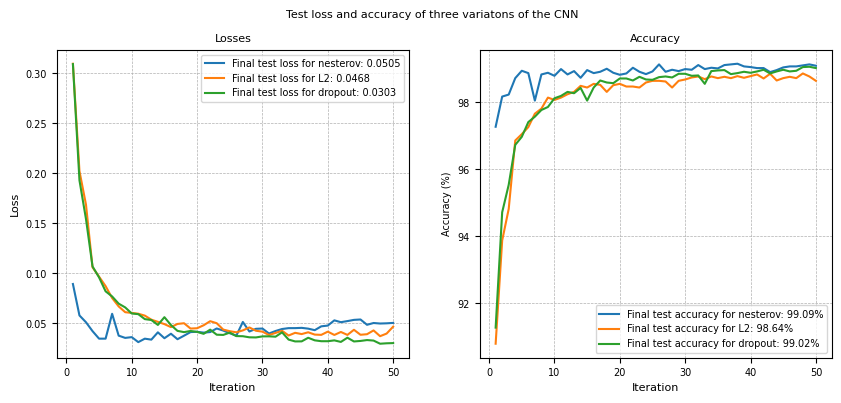

In [26]:
# Only include keys named "nesterov, l2, dropout"
model_variants = {k: models[k] for k in ['nesterov', 'L2', 'dropout']}
compare_models(model_variants, "Test loss and accuracy of three variatons of the CNN")

### Confusion Matrix of best performing model & Missclassifications of 10 images


In [51]:
from torcheval.metrics.functional import multiclass_confusion_matrix

predictions = torch.argmax(modeli(X_test_3Dtensor), dim=1)
true_labels = torch.argmax(Y_test_tensor, dim=1)

confusion_matrix = multiclass_confusion_matrix(predictions, true_labels, 10)
print(confusion_matrix)               
                

tensor([[ 977,    0,    1,    0,    0,    0,    0,    1,    1,    0],
        [   0, 1129,    0,    1,    0,    1,    2,    1,    1,    0],
        [   1,    0, 1023,    0,    0,    0,    0,    5,    3,    0],
        [   0,    0,    1, 1005,    0,    3,    0,    0,    1,    0],
        [   0,    0,    0,    0,  973,    0,    3,    0,    0,    6],
        [   0,    0,    0,    7,    0,  884,    1,    0,    0,    0],
        [   5,    2,    1,    0,    1,    5,  943,    0,    1,    0],
        [   0,    2,    4,    0,    0,    0,    0, 1018,    1,    3],
        [   3,    0,    2,    1,    0,    0,    0,    1,  966,    1],
        [   0,    0,    0,    1,    8,    2,    0,    6,    1,  991]])


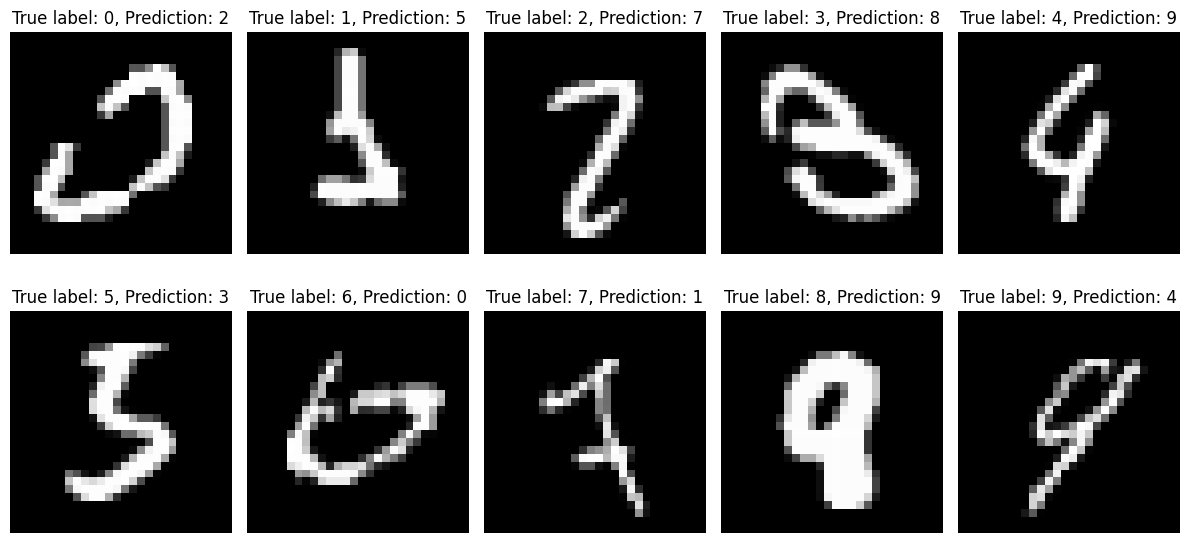

In [53]:

predicted = predictions.to('cpu').numpy()
labels = true_labels.to('cpu').numpy()
wrong_indices = np.where(predicted != labels)[0]

selected_wrong_indices = {i: None for i in range(10)}

for index in wrong_indices:
    if selected_wrong_indices[labels[index]] is None:
        selected_wrong_indices[labels[index]] = (X_test_3Dtensor[index].cpu().squeeze(), predicted[index], labels[index])
    
fig, axs = plt.subplots(2, 5, figsize=(12, 6))
for i, (image, prediction, label) in selected_wrong_indices.items():
    axs[i//5, i%5].imshow(image, cmap='gray')
    axs[i//5, i%5].set_title(f'True label: {label}, Prediction: {prediction}')
    axs[i//5, i%5].axis('off')
plt.tight_layout()